# QGAN
Quantum Generative Adversarial Network capable of generating novel MNIST images. Created by QMIND's Disruptive Technology team consisting of Cameron Estabrooks, Jacob Ewaniuk, Adam Grace, Spencer Hill, and Joshua Otten. 

In [1]:
# Imports
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

from pennylane import numpy as np
from numpy import pi
from numpy import linalg as la

import pennylane as qml
import cirq
import math as m
import numpy as np
from tqdm import tqdm # library for showing progress bars

from sklearn.preprocessing import MinMaxScaler

res = 4
numQubits = 2 * res + 1
numWeights = 3 * res - 1
dev = qml.device('cirq.simulator', wires=numQubits)

# Data Loading and Preparation
Load MNIST data, normalize it, and create new arrays with only the 3 and 9 digits

In [2]:
# Utility function to display images 
def display_image(X_data, image_num, Y_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(image_num):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_data[i], cmap='Greys')
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        if Y_labels is not None:
            plt.xlabel(Y_labels[i])
    plt.show()

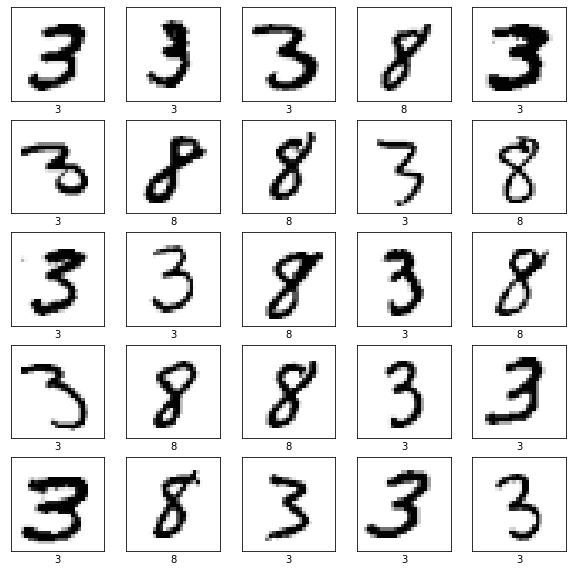

In [3]:
# Prepare and Load Data
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
full_X = np.concatenate((X_train, X_test))
full_Y = np.concatenate((Y_train, Y_test))
full_X = full_X / 255
other_X = full_X[:10000] # Paper only uses first 10000 images for training
other_Y = full_Y[:10000]
# Select only 3s and 8s
X = []
Y = []
for i in range(len(other_X)):
    if other_Y[i] == 3 or other_Y[i] == 8:
        X.append(other_X[i])
        Y.append(other_Y[i])
X = np.array(X)
Y = np.array(Y)

# Display select images
display_image(X, 25, Y)

# Image Encoding
Define functions to encode and decode MNSIST images. Methods available include a trained Variational Autoencoder and the Principle Component Analysis (PCA) algorithm.

In [4]:
# Load the trained autoencoder
def load_autoencoder():
    model = keras.models.load_model('mnist_enc/mnist_enc/')
    print(model.summary())
    layer = model.get_layer('dense_2')
    bottom_input = keras.layers.Input(model.input_shape[1:], name="Encoder Input")
    bottom_output = bottom_input
#     bottom_output = keras.layers.Input(model.input_shape[1:])
    top_input = keras.layers.Input(layer.output_shape[1:], name="Decoder Input")
    top_output = top_input

    bottom = True
    for layer in model.layers:
        if bottom and layer.name != 'input_1':
            bottom_output = layer(bottom_output)
        else:
            top_output = layer(top_output)
        if layer.name == 'dense_2':
            bottom = False

    enc_model = keras.Model(bottom_input, bottom_output)
    dec_model = keras.Model(top_input, top_output)
    return enc_model, dec_model

enc, dec = load_autoencoder()
print(enc.summary())
print(dec.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 dense_4 (Dense)             (None, 256)               16640     
                                                                 
 dense_5 (Dense)             (None, 784)               201488

In [5]:
# Encodes MNIST data into rotations. Return encoded data and the MinMaxScaler used to 
# normalize it (so it can be used to decode the compressed data)
def encode(encoder, data):
    encoded = encoder.predict(data.reshape(-1, 784))
    scaler = MinMaxScaler()
    scaler.fit(encoded)
    scaled_encoded = scaler.transform(encoded)
    qubitized_data = 2*np.arcsin(np.sqrt(scaled_encoded)) # Should play around with
    return qubitized_data, scaler

# Decodes compressed data
def decode(decoder, data, scaler):
    unscaled = scaler.inverse_transform(np.sin(data / 2) ** 2)
    return decoder.predict(unscaled).reshape(-1,28,28)

In [6]:
encoded_data, scaler = encode(enc, X)

[0.88842404 1.1144376  1.5042537  1.1585926 ]


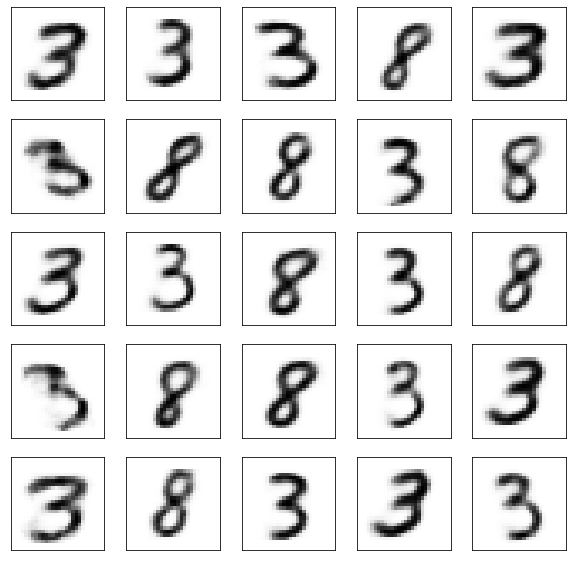

In [11]:
print(encoded_data[1])
test = decode(dec, encoded_data, scaler)
display_image(test, 25)

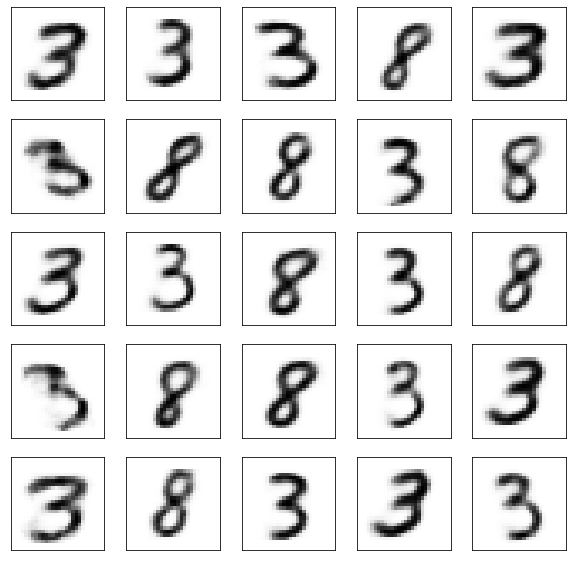

In [12]:
@qml.qnode(dev, interface="tf")
def test_circ(res, data):
    for i in range(0, res):
        qml.RY(data[i], wires=i)
    return [qml.expval(qml.PauliZ(i)) for i in range(4)]

test_data = [test_circ(res, encoded_data[i]) for i in range(25)]
test_img = decode(dec, encoded_data, scaler)
display_image(test_img, 25)

## Initialize weights

In [7]:
disc_weights = tf.Variable(np.pi * np.random.uniform(size=(numWeights,)))
gen_weights = tf.Variable(np.pi * np.random.uniform(size=(numWeights,)))

print(disc_weights)
print(gen_weights)

<tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([0.84068502, 2.61145853, 0.45294196, 0.04034096, 0.60686194,
       0.03941928, 1.88742296, 1.87686331, 1.4227404 , 0.09531981,
       0.42337895])>
<tf.Variable 'Variable:0' shape=(11,) dtype=float64, numpy=
array([2.18585844, 2.46194266, 2.56305906, 0.46570659, 0.81863403,
       2.13974452, 2.06548175, 2.27287801, 2.07606807, 2.01759679,
       1.25793971])>


# Generator and Discriminator Models


In [8]:
def generator(thetas, res):
    for i in range(res):
        qml.RY(thetas[i], wires=i+1+res)

    for i in range(res-1):
        qml.IsingYY(thetas[i+res], wires=[i+1+res, i+2+res])
    
    for i in range(res):
        if (i+2)%res == 0:
            qml.CRY(thetas[i+2*res-1], wires=[i+1+res, 2*res])
        else:
            qml.CRY(thetas[i+2*res-1], wires=[i+1+res, ((i+2)%res)+res])

In [9]:
def discriminator(thetas, res):
    for i in range(res):
        qml.RY(thetas[i], wires=i+1)
    
    for i in range(res-1):
        qml.IsingYY(thetas[i+res], wires=[i+1, i+2])
    
    for i in range(res):
        if (i+2)%res == 0:
            qml.CRY(thetas[i+2*res-1], wires=[i+1, res])
        else:
            qml.CRY(thetas[i+2*res-1], wires=[i+1, (i+2)%res])

# Full QGAN Circuit

In [10]:
@qml.qnode(dev, interface="tf")
def createCircuit(disc_weights, gen_weights, res, real=False, real_data=None):
    qml.Hadamard(wires=0)
    discriminator(disc_weights, res)
    if not real:
        generator(gen_weights, res)
        
    if real:
        # Encode real data into Quantum Circuit
        for i in range(0, res):
            qml.RY(real_data[i], wires=i+1+res)
            
    for i in range(res):
        qml.CSWAP(wires=[0, i+1, i+1+res])
    qml.Hadamard(wires=0)

    return qml.expval(qml.PauliZ(0))

# Cost Functions

In [11]:
# def disc_cost(disc_weights, gen_weights, res):
#     real_fidelity = genCircuit(disc_weights, gen_weights, res)
#     gen_fidelity = genCircuit(disc_weights, gen_weights, res, real=False)
#     print(real_fidelity, gen_fidelity)
# #     return m.log(real_fidelity) + m.log(1-gen_fidelity)
#     return tf.math.log(real_fidelity) + tf.math.log(1-gen_fidelity)

# def gen_cost(disc_weights, gen_weights, res):
#     gen_fidelity = genCircuit(disc_weights, gen_weights, res, real=False)
# #     return m.log(gen_fidelity)
#     return tf.math.log(gen_fidelity)

def real_disc_cost(expectation):
    if expectation <= 0.005: # They did in the paper
        expectation = 0.005
    return -tf.math.log(expectation)

def fake_disc_cost(expectation):
    if expectation <= 0.005:
        expectation = 0.005
    return -tf.math.log(1-expectation)
    
def gen_cost(expectation):
    if expectation <= 0.005:
        expectation = 0.005
    return -tf.math.log(expectation) # Maybe incorrect?

In [12]:
def parameter_shift_term(cost, i, params=None):
    if params is None:
        # disc_model (boolean) : which parameters are being shifted, generator's if False.
        # real (boolean) : whether real data is being used
        params = {"disc_model" : True, "real" : False, "real_data" : None}
    if params["disc_model"]:
        shifted = disc_weights.numpy().copy()
        shifted[i] += np.pi/2
        exp = createCircuit(shifted, gen_weights, res, real=params["real"], real_data=params["real_data"])
    else:
        shifted = gen_weights.numpy().copy()
        shifted[i] += np.pi/2
        exp = createCircuit(disc_weights, shifted, res, real=False, real_data=None)
    forward = cost(exp)  # forward evaluation
    
    if params["disc_model"]:
        shifted[i] -= np.pi
        exp = createCircuit(shifted, gen_weights, res, real=params["real"], real_data=params["real_data"])
    else:
        shifted[i] -= np.pi/2
        exp = createCircuit(disc_weights, shifted, res, real=False, real_data=None)
    backward = cost(exp) # backward evaluation

    return (0.5 * (forward.numpy() - backward.numpy()))

In [13]:
def calc_gradient(cost, params):
    grad = [0] * numWeights
    for i in range(numWeights):
        grad[i] = parameter_shift_term(cost, i, params=params)
    return np.array(grad)

In [14]:
params = {"disc_model" : True, "real" : True, "real_data" : encoded_data[0]}
grad = parameter_shift_term(fake_disc_cost, 0, params)
print(grad)

-0.04421918300282121


In [15]:
grad = calc_gradient(fake_disc_cost, params)
print(grad)

[-0.04421918 -0.10214318 -0.00517794  0.01947957 -0.01980082 -0.03650784
 -0.07084756 -0.02572021 -0.01574248  0.01294511 -0.00386693]


In [16]:
drawer = qml.draw(createCircuit)
print(drawer(disc_weights, gen_weights, res, real=False))

 0: ──H──────────────────────────────────────────────────────────────────────────────────────────────────╭C─────╭C─────╭C─────╭C─────H──┤ ⟨Z⟩ 
 1: ──RY(0.841)───╭IsingYY(0.607)────────────────────╭C──────────────────────────────────────╭RY(0.423)──├SWAP──│──────│──────│─────────┤     
 2: ──RY(2.61)────╰IsingYY(0.607)──╭IsingYY(0.0394)──╰RY(1.88)───────╭C──────────────────────│───────────│──────├SWAP──│──────│─────────┤     
 3: ──RY(0.453)────────────────────╰IsingYY(0.0394)──╭IsingYY(1.89)──╰RY(1.42)──╭C───────────│───────────│──────│──────├SWAP──│─────────┤     
 4: ──RY(0.0403)─────────────────────────────────────╰IsingYY(1.89)─────────────╰RY(0.0953)──╰C──────────│──────│──────│──────├SWAP─────┤     
 5: ──RY(2.19)────╭IsingYY(0.819)────────────────────╭C──────────────────────────────────────╭RY(1.26)───╰SWAP──│──────│──────│─────────┤     
 6: ──RY(2.46)────╰IsingYY(0.819)──╭IsingYY(2.14)────╰RY(2.27)───────╭C──────────────────────│──────────────────╰SWAP──│──────│─────────┤     

# Training Functions

In [17]:
# Function that produces average measurements from trained generator
@qml.qnode(dev)
def generate_output(weights):
    generator(weights, res)
    return [qml.expval(qml.PauliZ(i+res+1)) for i in range(res)]

In [18]:
@qml.qnode(dev, interface="tf")
def gen_loss():
    generator(gen_weights, res)
    return gen_cost(qml.expval(qml.PauliZ(0)))

def train_step(real_data, hp=None):
    global disc_weights, gen_weights
    if hp is None:
        # R (int) : Disc - Gen train count
        hp = {"R" : len(encoded_data), "I" : len(encoded_data) // 10, "batch_size" : 1, "learning_rate" : 0.01}
    # Discriminator on real data
    print("Discriminator on real")
    for i in tqdm(range(len(real_data)// hp["batch_size"])): 
        average_grad = np.array([0] * numWeights, dtype="float64")
        for image in real_data[i*hp["batch_size"]:(i+1)*hp["batch_size"]]:
            params = {"disc_model" : True, "real" : True, "real_data" : image}
            gradient = calc_gradient(real_disc_cost, params) # Have to find the actual format for gradient to use tf.apply_gradients
            average_grad = average_grad + gradient
        average_grad /= hp["batch_size"]
        
        # Apply gradient
        disc_weights = disc_weights - hp["learning_rate"]*average_grad
    # Discriminator on fake data
    print("Discriminator on fake")
    for _ in tqdm(range(hp["R"])):
        params = {"disc_model" : True, "real" : False, "real_data" : None}
        gradient = calc_gradient(fake_disc_cost, params)
        # Apply gradient
        disc_weights = disc_weights - hp["learning_rate"]*gradient
        
    print("Generator")
    for _ in tqdm(range(hp["I"])):
        params = {"disc_model" : False, "real" : False, "real_data" : None}
        gradient = calc_gradient(gen_cost, params)
        
        gen_weights = gen_weights - 2.5*hp["learning_rate"]*gradient
        # They use 10 times less t"raining steps for generator but a 2.5 times higher learning rate.
        # Apply gradient
    
   

In [19]:
def train(real_data, epochs=25, hp=None, reset=True, num_shots=30):
    global disc_weights, gen_weights
    if reset:
        disc_weights = tf.Variable(np.pi * np.random.uniform(size=(numWeights,)))
        gen_weights = tf.Variable(np.pi * np.random.uniform(size=(numWeights,)))
        v_gen = 0
        v_disc = 0
    
    for i in range(epochs):
        print("Epoch {} of {}".format(i+1, epochs))
        train_step(real_data, hp)
        # Printing out loss/visualizing examples at certain training steps.
        print("Cost: {}".format(gen_cost(createCircuit(disc_weights, gen_weights, res, real=False))))
        data = (generate_output(gen_weights, shots=num_shots) + 1) / 2
        image = decode(dec, data.reshape(1,-1), scaler)
        display_image(image, 1)

In [ ]:
train_step(encoded_data, hp={"R" : 10, "I" : 1, "batch_size" : 5, "learning_rate" : 0.01})

In [52]:
print(gen_cost(createCircuit(disc_weights, gen_weights, res, real=False)))

tf.Tensor(2.350158937389288, shape=(), dtype=float64)
1976


Epoch 1 of 25
Discriminator on real


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


Discriminator on fake


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.41it/s]


Generator


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.46it/s]

Cost: 2.0309919653544104


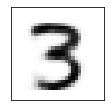

Epoch 2 of 25
Discriminator on real


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]


Discriminator on fake


  1%|▊                                                                                 | 1/100 [00:00<00:38,  2.56it/s]

In [ ]:
train(encoded_data[:100], hp={"R" : 100, "I" : 10, "batch_size" : 5, "learning_rate" : 0.01})

# Generate Output
Use trained generator to generate MNIST images. 

In [86]:
num_shots = 30
data = (generate_output(gen_weights, shots=num_shots) + 1) / 2
print(data)
image = decode(dec, data.reshape(1,-1), scaler)

[0.53333333 0.36666667 0.6        0.5       ]


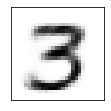

In [87]:
display_image(image, 1)

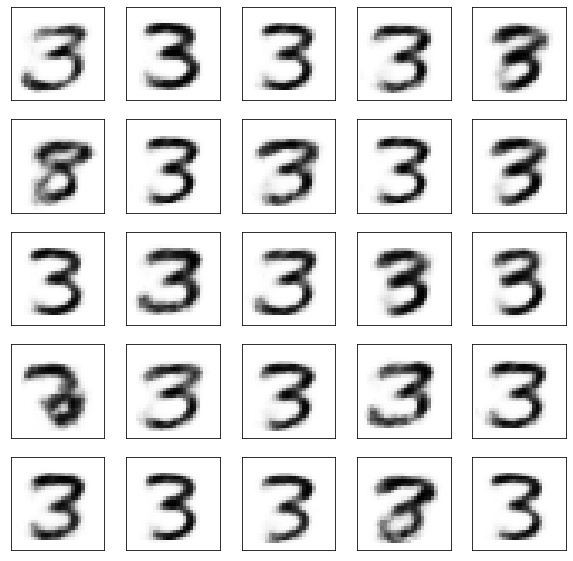

In [100]:
images = []
outputs = []
for i in range(25):
    outputs.append((generate_output(gen_weights, shots=10) + 1) / 2)
images = [decode(dec, x.reshape(1, -1), scaler).reshape((28, 28)) for x in outputs]
display_image(images, 25)

# Evalutation

In [1]:
# --------- Can use for quantum or classical data -----------
# Takes two probability distributions (two arrays where all the numbers in each array sum to one)
def hellinger_distance(pDistribution, qDistribution):
    hDistance = 0
    for pVal,qVal in zip(pDistribution,qDistribution):
        hDistance += (pVal**0.5 - qVal**0.5)**2
    hDistance = (1/(2**0.5))*(hDistance**0.5) 
    return hDistance

# Testing the function with basic example (it works)
print(hellinger_distance([0.36, 0.48, 0.16], [0.3333333, 0.3333333, 0.3333333]))


0.15049827134518493
